Data cleanning: remove duplicate images and resize image to 256,256 and RGB mode

In [9]:
from data_preprocessing.data_cleanning import Data_cleanning
data_cleanning = Data_cleanning()
data_cleanning.remove_duplicated_image('ai_generated_images/')
data_cleanning.remove_duplicated_image('human_generated_images/')


checking image number 0 
finished clean all images
checking image number 1 
finished clean all images
checking image number 2 
finished clean all images
checking image number 3 
finished clean all images
checking image number 4 
finished clean all images
checking image number 5 
finished clean all images
checking image number 6 
finished clean all images
checking image number 7 
finished clean all images
checking image number 8 
finished clean all images
checking image number 9 
finished clean all images
checking image number 10 
finished clean all images
checking image number 11 
finished clean all images
checking image number 12 
finished clean all images
checking image number 13 
finished clean all images
checking image number 14 
finished clean all images
checking image number 15 
finished clean all images
checking image number 16 
finished clean all images
checking image number 17 
finished clean all images
checking image number 18 
finished clean all images
checking image number 

Data Redcution: reduce the number of AI-generated images and human-genereated image to a balance state. due to space contrain on github, we gonna reduce the number of image to 50 using random sampling.

In [3]:
from data_preprocessing.data_reduction import Data_reduction
# if output "The number of images is less than the sampling size" that mean the dataset is already being reduced
Data_reduction = Data_reduction(50)
Data_reduction.random_sampling('ai_generated_images/')
Data_reduction.random_sampling('human_generated_images/')

50
The number of images is less than the sampling size
50
The number of images is less than the sampling size


Data labeling: lable the dataset for our supervised model

In [10]:
from data_preprocessing.data_labeling import Data_labeling
ai_data_labeling = Data_labeling()
#label ai-generated images as 0
ai_images, ai_label = ai_data_labeling.labeling('ai_generated_images/', 0)
human_data_labeling = Data_labeling()
#label human-generated images as 1
human_images, human_label = human_data_labeling.labeling('human_generated_images/', 1)
# For testing purpose we not going to save the data, using the exsiting npy file for train the model.
# np.save('ai_images.npy', ai_images)
# np.save('ai_label.npy', ai_label)
# np.save('human_images.npy', human_images)
# np.save('human_label.npy', human_label)
print('ai-generated image array shape: ',ai_images.shape) #(2999, 256, 256, 3)
print('ai-generated label array shape: ',ai_label.shape) #(2999,)
print('human-generated image array shape: ',human_images.shape)#(2999, 256, 256, 3)
print('human-generated label array shape: ',human_label.shape)#(2999,)

ai-generated image array shape:  (50, 256, 256, 3)
ai-generated label array shape:  (50,)
human-generated image array shape:  (50, 256, 256, 3)
human-generated label array shape:  (50,)


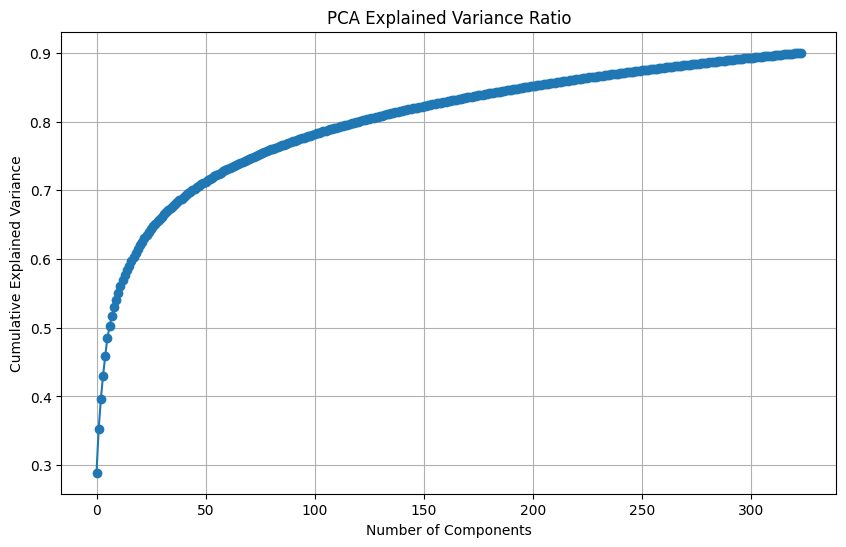

Accuracy: 0.65
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.62      0.65       927
           1       0.63      0.68      0.65       873

    accuracy                           0.65      1800
   macro avg       0.65      0.65      0.65      1800
weighted avg       0.65      0.65      0.65      1800



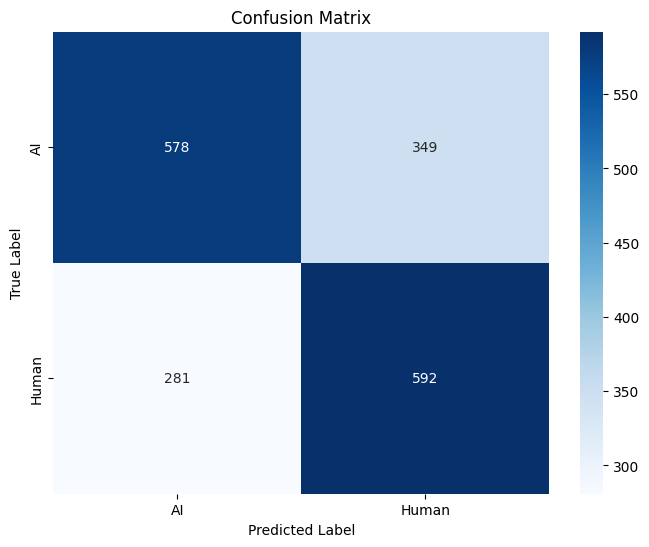

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import parallel_backend

# Load the data
ai_images = np.load('ai_images.npy')
ai_label = np.load('ai_label.npy')
human_images = np.load('human_images.npy')
human_label = np.load('human_label.npy')

# Flatten the images
ai_images_flat = ai_images.reshape(len(ai_images), -1)
human_images_flat = human_images.reshape(len(human_images), -1)

# Concatenate the data and labels
X = np.concatenate((ai_images_flat, human_images_flat), axis=0)
y = np.concatenate((ai_label, human_label), axis=0)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Optionally downsample the training data for quicker testing
X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.7, random_state=42)

# Create a pipeline with StandardScaler, PCA, and LinearSVC
pipeline = Pipeline(steps=[ ('scaler', StandardScaler()),('pca', PCA(n_components=0.90)), ('linear_svc', LinearSVC(dual=False, max_iter=1000)) 
])

with parallel_backend('threading', n_jobs=-1):
    pipeline.fit(X_train, y_train)

pca = pipeline.named_steps['pca']
explained_variance = pca.explained_variance_ratio_

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance Ratio')
plt.grid(True)
plt.show()

# Make predictions
y_pred = pipeline.predict(X_test)
y_pred_pipeline = y_pred

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Original AI images shape: (2999, 256, 256, 3)
Original Human images shape: (2999, 256, 256, 3)
Resized AI images shape: (2999, 28, 28, 3)
Resized Human images shape: (2999, 28, 28, 3)
AI images reshaped: (2999, 28, 28, 3)
Human images reshaped: (2999, 28, 28, 3)
Train images shape: (4198, 28, 28, 3)
Test images shape: (1800, 28, 28, 3)
Epoch 1/5


/Users/Dooliemadness/Desktop/MLGROUP/Group/ML-group1/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4921 - loss: 0.6934 - val_accuracy: 0.4967 - val_loss: 0.6931
Epoch 2/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5128 - loss: 0.6932 - val_accuracy: 0.4967 - val_loss: 0.6931
Epoch 3/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5164 - loss: 0.6922 - val_accuracy: 0.5544 - val_loss: 0.6838
Epoch 4/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5773 - loss: 0.6751 - val_accuracy: 0.6172 - val_loss: 0.6619
Epoch 5/5
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6092 - loss: 0.6610 - val_accuracy: 0.6117 - val_loss: 0.6629
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6050 - loss: 0.6668
Test accuracy: 0.6116666793823242


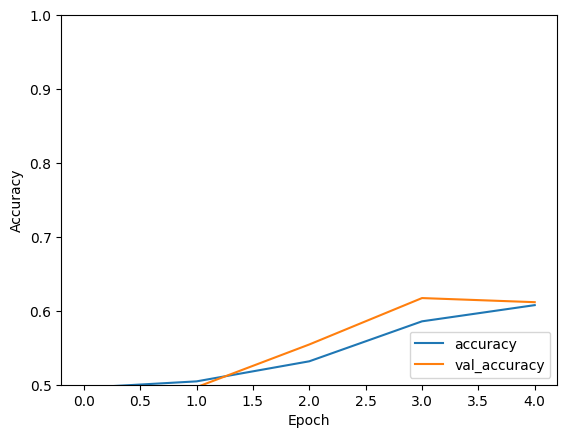

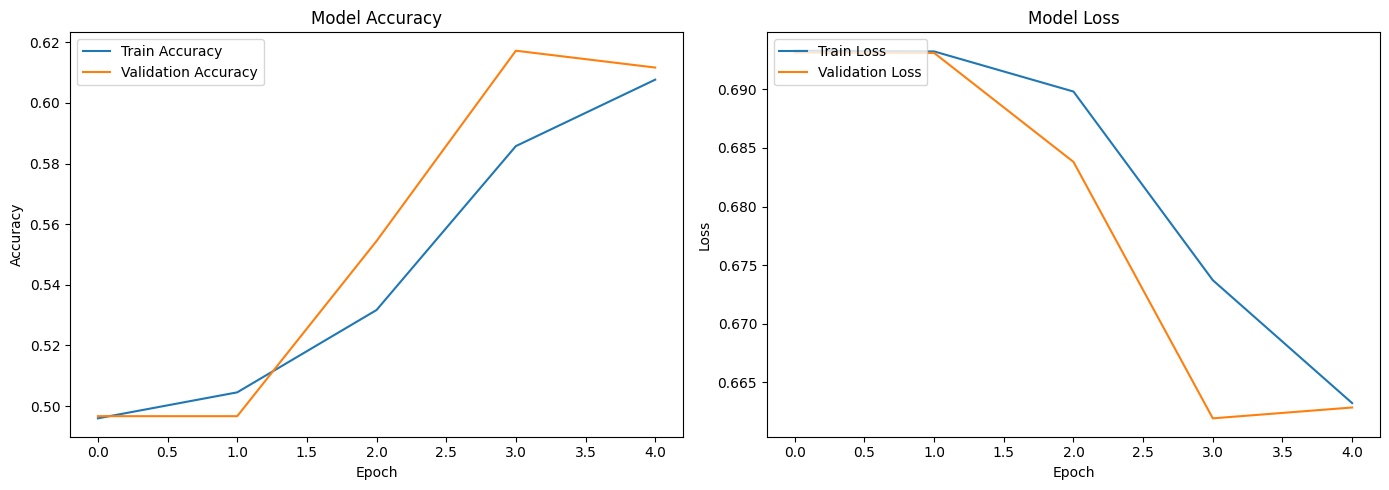

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split

# Load the data
ai_images = np.load('ai_images.npy')
ai_label = np.load('ai_label.npy')
human_images = np.load('human_images.npy')
human_label = np.load('human_label.npy')

print(f"Original AI images shape: {ai_images.shape}")
print(f"Original Human images shape: {human_images.shape}")

# Resize images to 28x28
ai_images_resized = np.array([resize(image, (28, 28, 3)) for image in ai_images])
human_images_resized = np.array([resize(image, (28, 28, 3)) for image in human_images])

print(f"Resized AI images shape: {ai_images_resized.shape}")
print(f"Resized Human images shape: {human_images_resized.shape}")

print(f"AI images reshaped: {ai_images_resized.shape}")
print(f"Human images reshaped: {human_images_resized.shape}")

# Combine the data and labels
X = np.concatenate((ai_images_resized, human_images_resized), axis=0)
y = np.concatenate((ai_label, human_label), axis=0)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Normalize the images
train_images, test_images = X_train / 255.0, X_test / 255.0

# Ensure reshaped correctly
print('Train images shape:', train_images.shape)
print('Test images shape:', test_images.shape)

# Build the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Add Dense layers on top
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, y_train, epochs=5, 
                    validation_data=(test_images, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, y_test)
print(f"Test accuracy: {test_acc}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

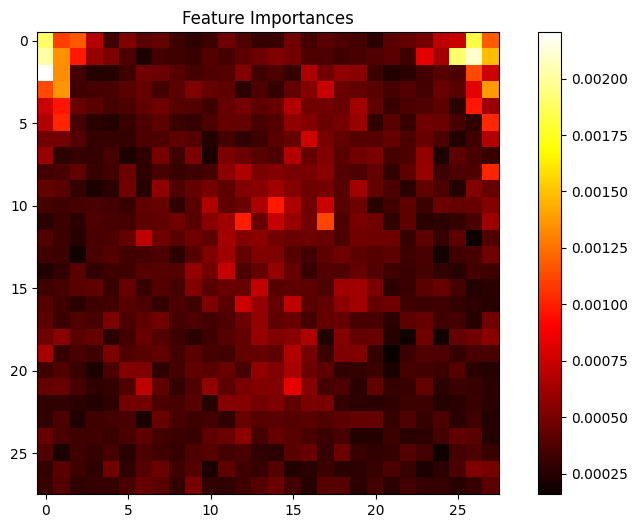

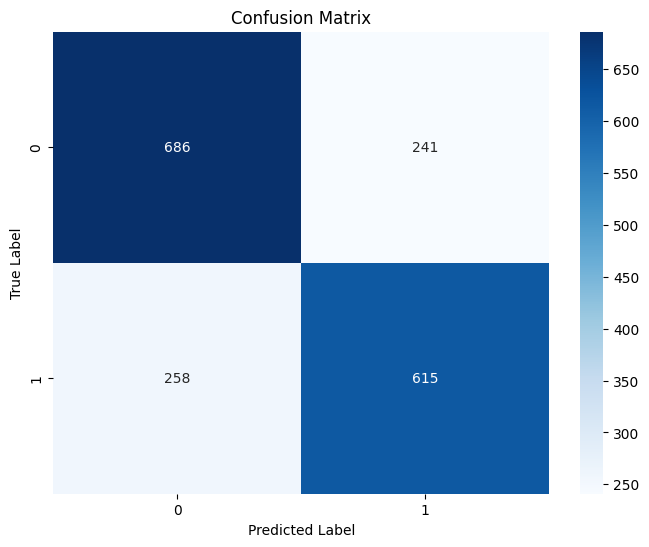

Test accuracy: 0.7227777777777777


In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the data
ai_images = np.load('ai_images.npy')
ai_label = np.load('ai_label.npy')
human_images = np.load('human_images.npy')
human_label = np.load('human_label.npy')

# for quicker processing
ai_images_resized = np.array([resize(image, (28, 28, 3)) for image in ai_images])
human_images_resized = np.array([resize(image, (28, 28, 3)) for image in human_images])

ai_images_flat = ai_images_resized.reshape(len(ai_images_resized), -1)
human_images_flat = human_images_resized.reshape(len(human_images_resized), -1)
X = np.concatenate((ai_images_flat, human_images_flat), axis=0)
y = np.concatenate((ai_label, human_label), axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)
y_pred_rf = y_pred

# Feature Importances
feature_importances = rf_classifier.feature_importances_
# Calculate the average feature importance per pixel across color channels
feature_importances_reshaped = feature_importances.reshape(28, 28, 3).mean(axis=2)
plt.figure(figsize=(10, 6))
plt.imshow(feature_importances_reshaped, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Feature Importances')
plt.show()
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy}")

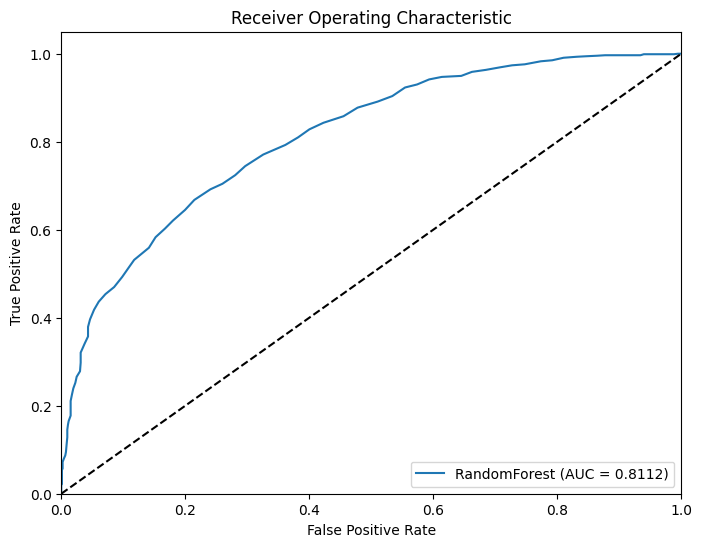

In [46]:
# ROC Curve
y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'RandomForest (AUC = {roc_auc_score(y_test, y_pred_prob):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [47]:
# Function to print metrics
def print_metrics(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\n")

# Print metrics for the RandomForest model
print_metrics(y_test, y_pred, "RandomForest")



RandomForest Metrics:
Accuracy: 0.7228
Precision: 0.7185
Recall: 0.7045
F1 Score: 0.7114
ROC AUC: 0.8112




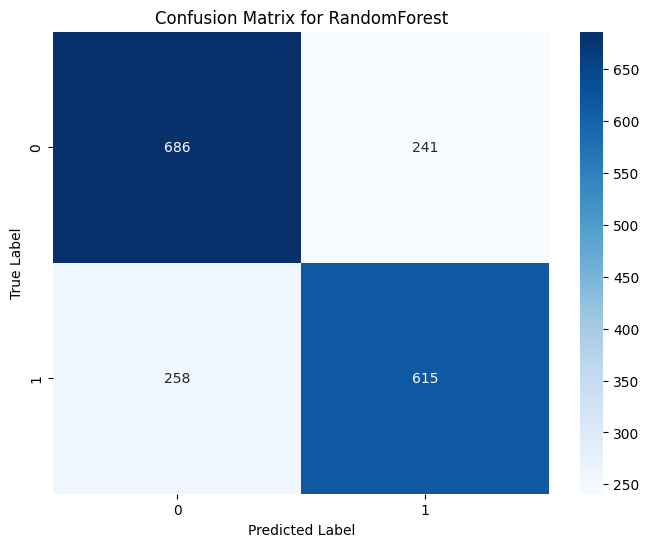

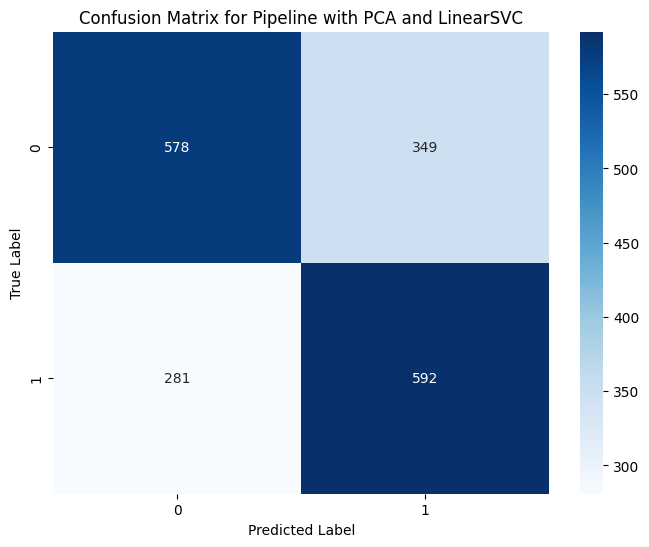

In [48]:
# Plot confusion matrices
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Compute confusion matrices
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_pipeline = confusion_matrix(y_test, y_pred_pipeline)

# Plot confusion matrices for each model
plot_confusion_matrix(cm_rf, title='Confusion Matrix for RandomForest')
plot_confusion_matrix(cm_pipeline, title='Confusion Matrix for Pipeline with PCA and LinearSVC')



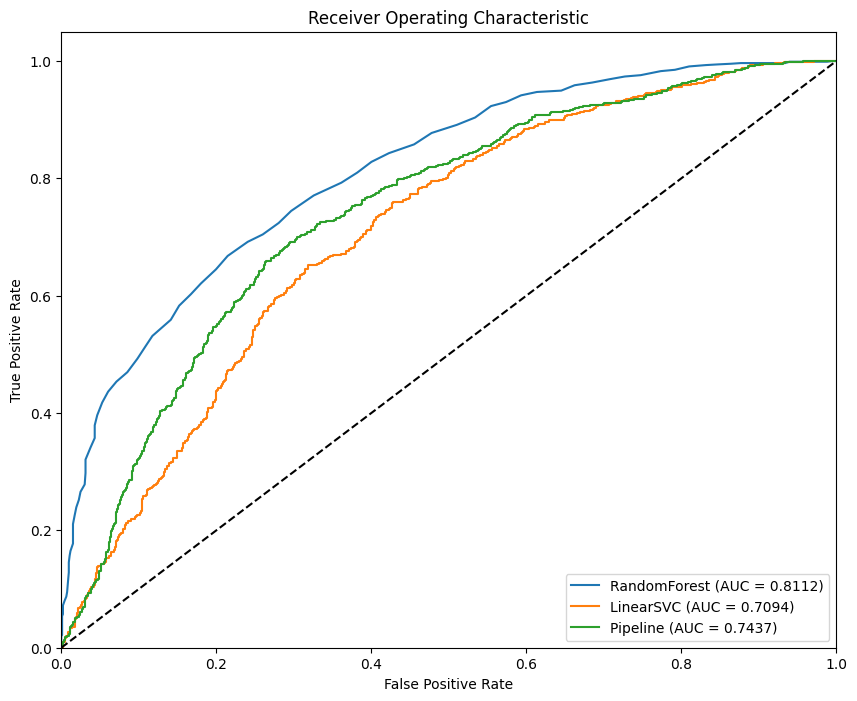

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from skimage.transform import resize

# Load the datasets
ai_images = np.load('ai_images.npy')
ai_label = np.load('ai_label.npy')
human_images = np.load('human_images.npy')
human_label = np.load('human_label.npy')

# Resize images to 28x28 for quicker processing
ai_images_resized = np.array([resize(image, (28, 28, 3)) for image in ai_images])
human_images_resized = np.array([resize(image, (28, 28, 3)) for image in human_images])

# Flatten images
ai_images_flat = ai_images_resized.reshape(len(ai_images_resized), -1)
human_images_flat = human_images_resized.reshape(len(human_images_resized), -1)

# Concatenate data and labels
X = np.concatenate((ai_images_flat, human_images_flat), axis=0)
y = np.concatenate((ai_label, human_label), axis=0)

# Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.ensemble import RandomForestClassifier

# Train RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
y_pred_prob_rf = rf_classifier.predict_proba(X_test)[:, 1]  # For ROC curve

from sklearn.svm import LinearSVC

# Train LinearSVC
svc_classifier = LinearSVC()
svc_classifier.fit(X_train, y_train)
y_pred_svc = svc_classifier.predict(X_test)
y_pred_prob_svc = svc_classifier.decision_function(X_test)  # For ROC curve

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=50)),
    ('svc', LinearSVC(random_state=42))
])
pipeline.fit(X_train, y_train)
y_pred_pipeline = pipeline.predict(X_test)
y_pred_prob_pipeline = pipeline.decision_function(X_test)  # For ROC curve

# Calculate ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_pred_prob_svc)
fpr_pipeline, tpr_pipeline, _ = roc_curve(y_test, y_pred_prob_pipeline)

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC = {roc_auc_score(y_test, y_pred_prob_rf):.4f})')
plt.plot(fpr_svc, tpr_svc, label=f'LinearSVC (AUC = {roc_auc_score(y_test, y_pred_prob_svc):.4f})')
plt.plot(fpr_pipeline, tpr_pipeline, label=f'Pipeline (AUC = {roc_auc_score(y_test, y_pred_prob_pipeline):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Next Steps

Based on the results, the following observations and next steps can be made:

1. **RandomForest Classifier** showed good overall performance with a balanced accuracy, precision, and recall.
2. **LinearSVC** had a slightly lower performance compared to RandomForest but still performed well, especially in precision.
3. **Pipeline with PCA and LinearSVC** showed performance comparable to the standalone LinearSVC, indicating that PCA did not significantly impact the results.

**Potential Improvements:**
- **Data Augmentation:** Increase the dataset size using data augmentation techniques to provide more training examples for the models.
- **Hyperparameter Tuning:** Perform a thorough hyperparameter search to optimize model performance.
- **Ensemble Methods:** Combine the strengths of multiple models using ensemble methods to improve overall performance.
- **Feature Engineering:** Explore additional features that might help in better distinguishing between AI-generated and human-generated images.

